In [75]:
using TensorOperations, LinearAlgebra, Plots

## Working with MPS

### option 1: manually creating product state MPS

In [100]:
function PolarizedMPS(L::Int64)
    # Initialize an array to store matrices representing the polarized state MPS.
    psi = Array{Float64}[]

    # Iterate through each site in the 1D quantum system.
    for i in 1:L
        # For each site, add a matrix with coefficients [1.0, 0.0] to the array.
        push!(psi, reshape([1.0, 0.0], (1, 2, 1)))
    end

    # Return the array representing the polarized state MPS.
    return psi
end

function NeelMPS(L::Int64)
    # Initialize an array to store matrices representing the Neel state MPS.
    psi = Array{Float64}[]

    # Iterate through each site in the 1D quantum system.
    for i in 1:L
        # Check if the site index is odd (spin-up) or even (spin-down).
        if isodd(i)
            # For spin-up, add a matrix with coefficients [1.0, 0.0] to the array.
            push!(psi, reshape([1.0, 0.0], (1, 2, 1)))
        else
            # For spin-down, add a matrix with coefficients [0.0, 1.0] to the array.
            push!(psi, reshape([0.0, 1.0], (1, 2, 1)))
        end
    end

    # Return the array representing the Neel state MPS.
    return psi
end


NeelMPS (generic function with 1 method)

### option 2: from vector

In [101]:
function MPSrep_LC(psi::Vector{Float64}, maxM=0)
    """
    MPSrep_LC(psi::Vector{Float64}, maxM=0)

    Convert a state vector into a Matrix Product State (MPS) representation using singular value decomposition (SVD).

    # Arguments
    - `psi`: The state vector to be converted into MPS.
    - `maxM`: The maximum number of singular values to keep in each step. If 0, no truncation is performed.

    # Returns
    - `psi_mps`: Array of matrices representing the MPS.
    - `VN`: Array of von Neumann entropies at each step.
    - `Ms`: Array of the number of retained singular values at each step.
    - `Trunc`: Array of truncation errors at each step if maxM > 0 and truncation occurs.

    """
    D = size(psi)[1]
    logD = log2(D)
    @assert isinteger(logD) "State vector of incompatible length"
    L = Int(logD) # How many qubits in the state?
    psi_mps = []
    VN = []
    Ms = []
    Trunc = []

    psi_matrix = reshape(psi, (2, 2^(L-1)))

    for l in 1:L-1
        # Singular Value Decomposition (SVD)
        U, s, V = svd(psi_matrix)

        # Find the last non-zero singular value
        Ml = findlast(s .> 1e-14)

        # Retain only relevant parts of U, s, and V
        U, s, V = U[:, 1:Ml], s[1:Ml], V[:, 1:Ml]

        # Calculate von Neumann entropy
        w = s.^2
        svn = -sum(w .* log.(w))

        # If 0 < maxM < Ml - truncation, perform truncation
        if (maxM > 0 && Ml > maxM)
            trunc = sum(s[maxM:end].^2)
            push!(Trunc, trunc)
            U, s, V = U[:, 1:maxM], s[1:maxM], V[:, 1:maxM]
            s /= sqrt(1. - trunc)
            Ml = maxM
        end

        push!(Ms, Ml)
        push!(VN, svn)

        # Reshape U into the MPS format
        if (l == 1)
            push!(psi_mps, reshape(U, (1, 2, Ml)))
        else
            push!(psi_mps, reshape(U, (Ms[end-1], 2, Ml)))
        end

        # Reshape V into the MPS format for the next iteration
        if (l == L-1)
            push!(psi_mps, reshape(diagm(s) * V', (Ml, 2, 1)))
        else
            psi_matrix = reshape(diagm(s) * V', (2 * Ml, 2^(L-l-1)))
        end
    end

    return psi_mps, VN, Ms, Trunc
end


MPSrep_LC (generic function with 2 methods)

### option 3: random MPS (need to normalize)

In [102]:
function BondTensor(psi::Vector{Array{Float64}}, b::Int64)
    """
    BondTensor(psi::Vector{Array{Float64}}, b::Int64)

    Construct the bond tensor between two adjacent sites in a Matrix Product State (MPS).

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `b`: Index of the bond between adjacent sites (1 to length(psi)-1).

    # Returns
    - `psi_bond`: Bond tensor connecting sites `b` and `b+1`.

    """
    @assert b >= 1 && b <= (length(psi)-1) "Bond out of range"

    # Dimensions of matrices at site b and site b+1
    M0 = size(psi[b])[1]
    M2 = size(psi[b+1])[3]

    # Initialize the bond tensor
    psi_bond = zeros(M0, 2, 2, M2)

    # Contract matrices at site b and site b+1 to form the bond tensor
    @tensor psi_bond[l0, s1, s2, l2] = psi[b][l0, s1, l1] * psi[b+1][l1, s2, l2]

    return psi_bond
end


BondTensor (generic function with 1 method)

In [108]:
function SvdBondTensor!(psi::Vector{Array{Float64}}, b::Int64, psi_bond::Array{Float64}, ortho_left=true, maxM=-1, renorm=false)
    """
    SvdBondTensor!(psi::Vector{Array{Float64}}, b::Int64, psi_bond::Array{Float64}, ortho_left=true, maxM=-1, renorm=false)

    Update the Matrix Product State (MPS) by performing a Singular Value Decomposition (SVD) on the bond tensor.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `b`: Index of the bond between adjacent sites (1 to length(psi)-1).
    - `psi_bond`: Bond tensor connecting sites `b` and `b+1`.
    - `ortho_left`: If true, orthogonally update the matrix at site `b` (left-canonical). If false, orthogonally update the matrix at site `b+1` (right-canonical).
    - `maxM`: The maximum number of singular values to keep in each step. If -1, no truncation is performed.
    - `renorm`: If true, renormalize the singular values after the SVD.

    # Returns
    - `trunc`: Truncation error if truncation occurs, otherwise 0.

    """
    @assert length(size(psi_bond)) == 4 "psi_bond is expected to be a rank-4 tensor"

    trunc = 0.

    M0 = size(psi_bond)[1]
    M2 = size(psi_bond)[4]

    # Reshape the bond tensor into a matrix for SVD
    psi_bond_matrix = reshape(psi_bond, (M0*2, M2*2))

    # Perform SVD on the reshaped bond tensor matrix
    U, S, V = svd(psi_bond_matrix)

    # Optionally renormalize the singular values
    if renorm
        S /= norm(S)
    end

    # Find the last non-zero singular value
    M1 = findlast(S .> 1e-16)

    # Retain only relevant parts of U, S, and V
    U, S, V = U[:, 1:M1], S[1:M1], V[:, 1:M1]

    # If 0 < maxM < M1 - truncation, perform truncation
    if maxM > 0 && M1 > maxM
        trunc = sum(S[maxM:end].^2)
        U, S, V = U[:, 1:maxM], S[1:maxM], V[:, 1:maxM]
        S /= sqrt(1. - trunc)
        M1 = maxM
    end

    # Update the MPS matrices based on the SVD results
    if ortho_left
        psi[b] = reshape(U, (M0, 2, M1))
        psi[b+1] = reshape(Diagonal(S) * V', (M1, 2, M2))
    else
        psi[b] = reshape(U * Diagonal(S), (M0, 2, M1))
        psi[b+1] = reshape(V', (M1, 2, M2))
    end

    return trunc
end


SvdBondTensor! (generic function with 4 methods)

In [99]:
function RandomMPS(L::Int64, M::Int64)
    """
    RandomMPS(L::Int64, M::Int64)

    Generate a random Matrix Product State (MPS) for a 1D quantum system.

    # Arguments
    - `L`: The length of the 1D quantum system.
    - `M`: The bond dimension of the MPS.

    # Returns
    An array of random matrices representing the MPS.

    """
    psi = Array{Float64}[]

    for i in 1:L
        # Determine the bond dimensions for the current site
        M1 = i == 1 ? 1 : M
        M2 = i == L ? 1 : M

        # Generate a random matrix for the current site
        push!(psi, rand(Float64, M1, 2, M2))
    end

    return psi
end

RandomMPS (generic function with 1 method)

In [109]:
function NormalizePsi!(psi::Vector{Array{Float64}})
    """
    NormalizePsi!(psi::Vector{Array{Float64}})

    Normalize and bring the orthogonality center to the first site in a Matrix Product State (MPS), assuming right canonical form.

    # Arguments
    - `psi`: Array of matrices representing the MPS.

    """
    L = length(psi)

    # Iterate from the last site to the second site
    for i in L-1:-1:1
        # Calculate the bond tensor between current site i and i+1
        psi_bond = BondTensor(psi, i)

        # Orthogonally update the MPS using the Singular Value Decomposition (SVD), assuming right canonical form
        SvdBondTensor!(psi, i, psi_bond, false, -1, true)
        # ortho_left = false => Update the matrix at site i+1 (right canonical form)
        # maxM = -1 => No truncation
        # renorm = true => Renormalize the singular values
    end
end

NormalizePsi! (generic function with 1 method)

## MPS struct

In [110]:
mutable struct MPSrep
    oc::Int64                        # orthogonality center
    maxM::Int64                      # maximal bond dimension
    state::Vector{Array{Float64}}  
    
    function MPSrep(psi::Vector{Float64}, maxM=-1)
        # initial MPS given in left-canonical form, oc at rightmost site
        state, VN, Ms, Trunc = MPSrep_LC(psi, maxM)
        oc = length(state)
        new(oc, maxM, state)
    end
    
    function MPSrep(psi::Vector{Array{Float64}})
        # initial MPS given in right-canonical form, oc at leftmost site
        oc = 1
        maxM = -1
        state = deepcopy(psi)
        new(oc, maxM, state)
    end
    
end

#### example 1 - cat state from vector

In [106]:
L = 3
D = 2^L
psi = zeros(D)
psi[1] = 1.  #cat state
psi[end] = 1. #cat state
psi ./= norm(psi)
psi_mps = MPSrep(psi)
@show(psi_mps.oc)
@show(psi_mps.maxM)

psi_mps.oc = 3
psi_mps.maxM = -1


-1

#### example 2 - random state 

In [111]:
L = 3

psi = RandomMPS(L, 2)
NormalizePsi!(psi)
psi_mps = MPSrep(psi)
@show(psi_mps.oc)
@show(psi_mps.maxM)


psi_mps.oc = 1
psi_mps.maxM = -1


-1

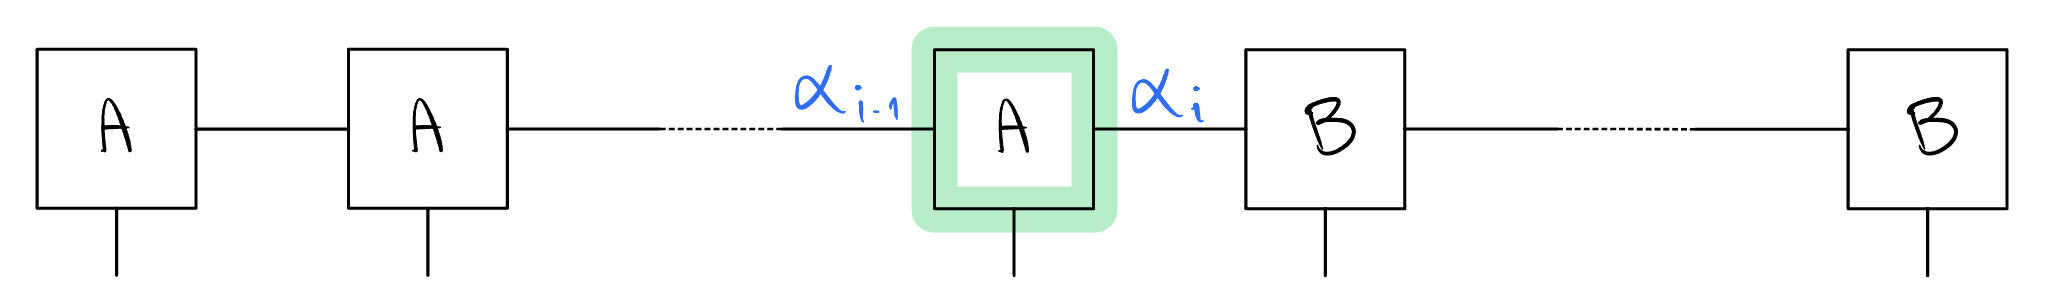

In [113]:
function OrthogonalizePsi!(psi_mps::MPSrep, i0::Int64)
    """
    OrthogonalizePsi!(psi_mps::MPSrep, i0::Int64)

    Bring the orthogonality center to site i0 in a Matrix Product State (MPS), updating the MPS representation.

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `i0`: The target site to which the orthogonality center (oc) should be moved.

    """
    L = length(psi_mps.state)
    oc = psi_mps.oc

    if i0 > oc
        # Move the orthogonality center to the right: Add more left canonical forms
        for i in oc:i0-1
            psi_bond = BondTensor(psi_mps.state, i)
            # ortho_left = true => Update the matrix at site i (left canonical form)
            # maxM = -1 => No truncation
            # renormalize = false => Do not renormalize the singular values
            SvdBondTensor!(psi_mps.state, i, psi_bond, true)
        end
    elseif i0 < oc
        # Move the orthogonality center to the left
        for i in oc-1:-1:i0
            psi_bond = BondTensor(psi_mps.state, i)
            # ortho_left = false => Update the matrix at site i+1 (right canonical form)
            # maxM = -1 => No truncation
            # renormalize = false => Do not renormalize the singular values
            SvdBondTensor!(psi_mps.state, i, psi_bond, false)
        end
    end

    # Update the orthogonality center
    psi_mps.oc = i0
end

OrthogonalizePsi! (generic function with 1 method)

# Expectation Values

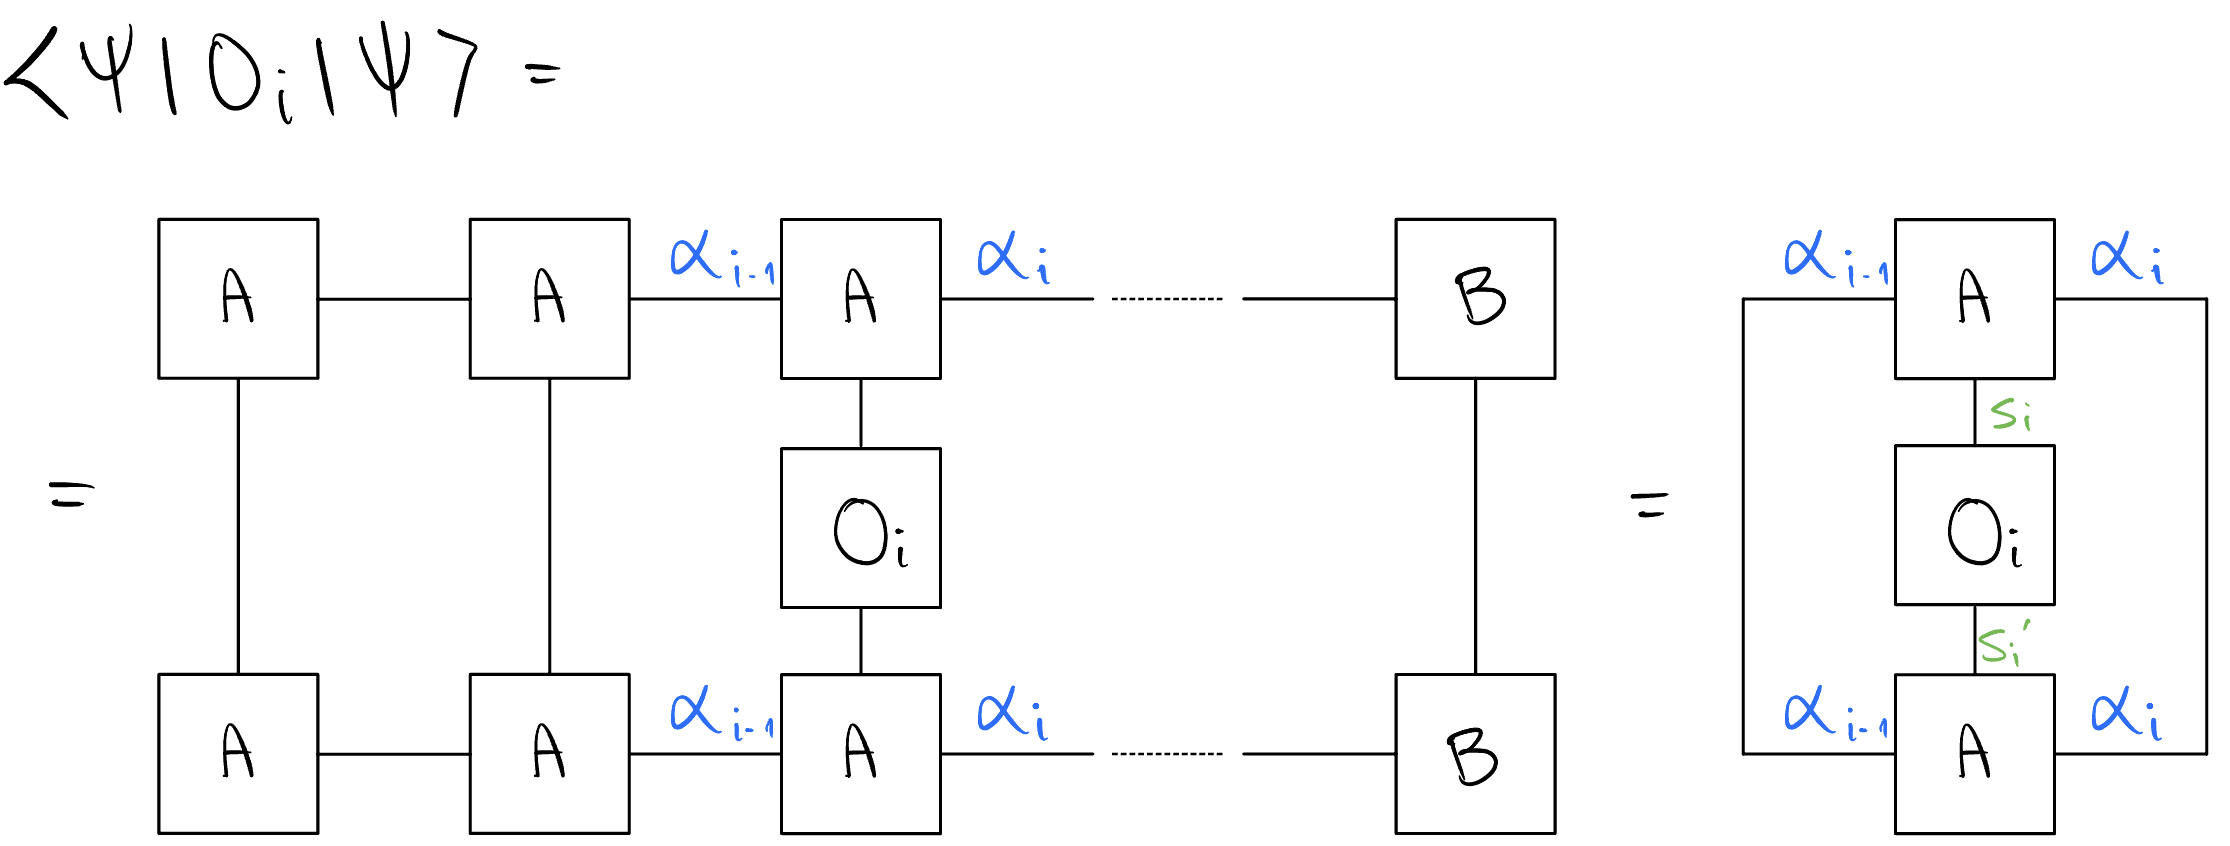

In [114]:
function ExpectationValue(psi_mps::MPSrep, Op)
    """
    ExpectationValue(psi_mps::MPSrep, Op)

    Calculate the expectation values of an operator (Op) for each site in a Matrix Product State (MPS).

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `Op`: The operator for which to calculate the expectation values.

    # Returns
    An array of expectation values for each site.

    """
    L = length(psi_mps.state)
    ExpVals = zeros(L)

    for i in 1:L
        # Orthogonalize the MPS up to site i
        OrthogonalizePsi!(psi_mps, i)

        # Extract the matrix Ai from the MPS representation at site i
        Ai = psi_mps.state[i]
        M0 = size(Ai)[1]
        M1 = size(Ai)[3]

        # Initialize the tensor representing Ai * Op
        Ai_Sop = zeros(M0, 2, M1)

        # Contract Ai with Op to obtain Ai_Sop tensor
        @tensor Ai_Sop[l0, sp, l1] = Ai[l0, s, l1] * Op[s, sp]

        # Calculate the expectation value
        @tensor Val = Ai_Sop[l0, sp, l1] * Ai[l0, sp, l1]
        ExpVals[i] = Val
    end

    return ExpVals
end

ExpectationValue (generic function with 1 method)

In [115]:
# spin-1/2 operators
Sx = [0.0 1.0; 1.0 0.0]
Sz = [1.0 0.0; 0.0 -1.0]

2×2 Matrix{Float64}:
 1.0   0.0
 0.0  -1.0

In [116]:
L = 5
D = 2^L
psi = zeros(D)
psi[1] = 1.  #cat state
psi[end] = 1. #cat state
psi ./= norm(psi)
psi_mps = MPSrep(psi)

SzVals = ExpectationValue(psi_mps, Sz)

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0

# Correlations

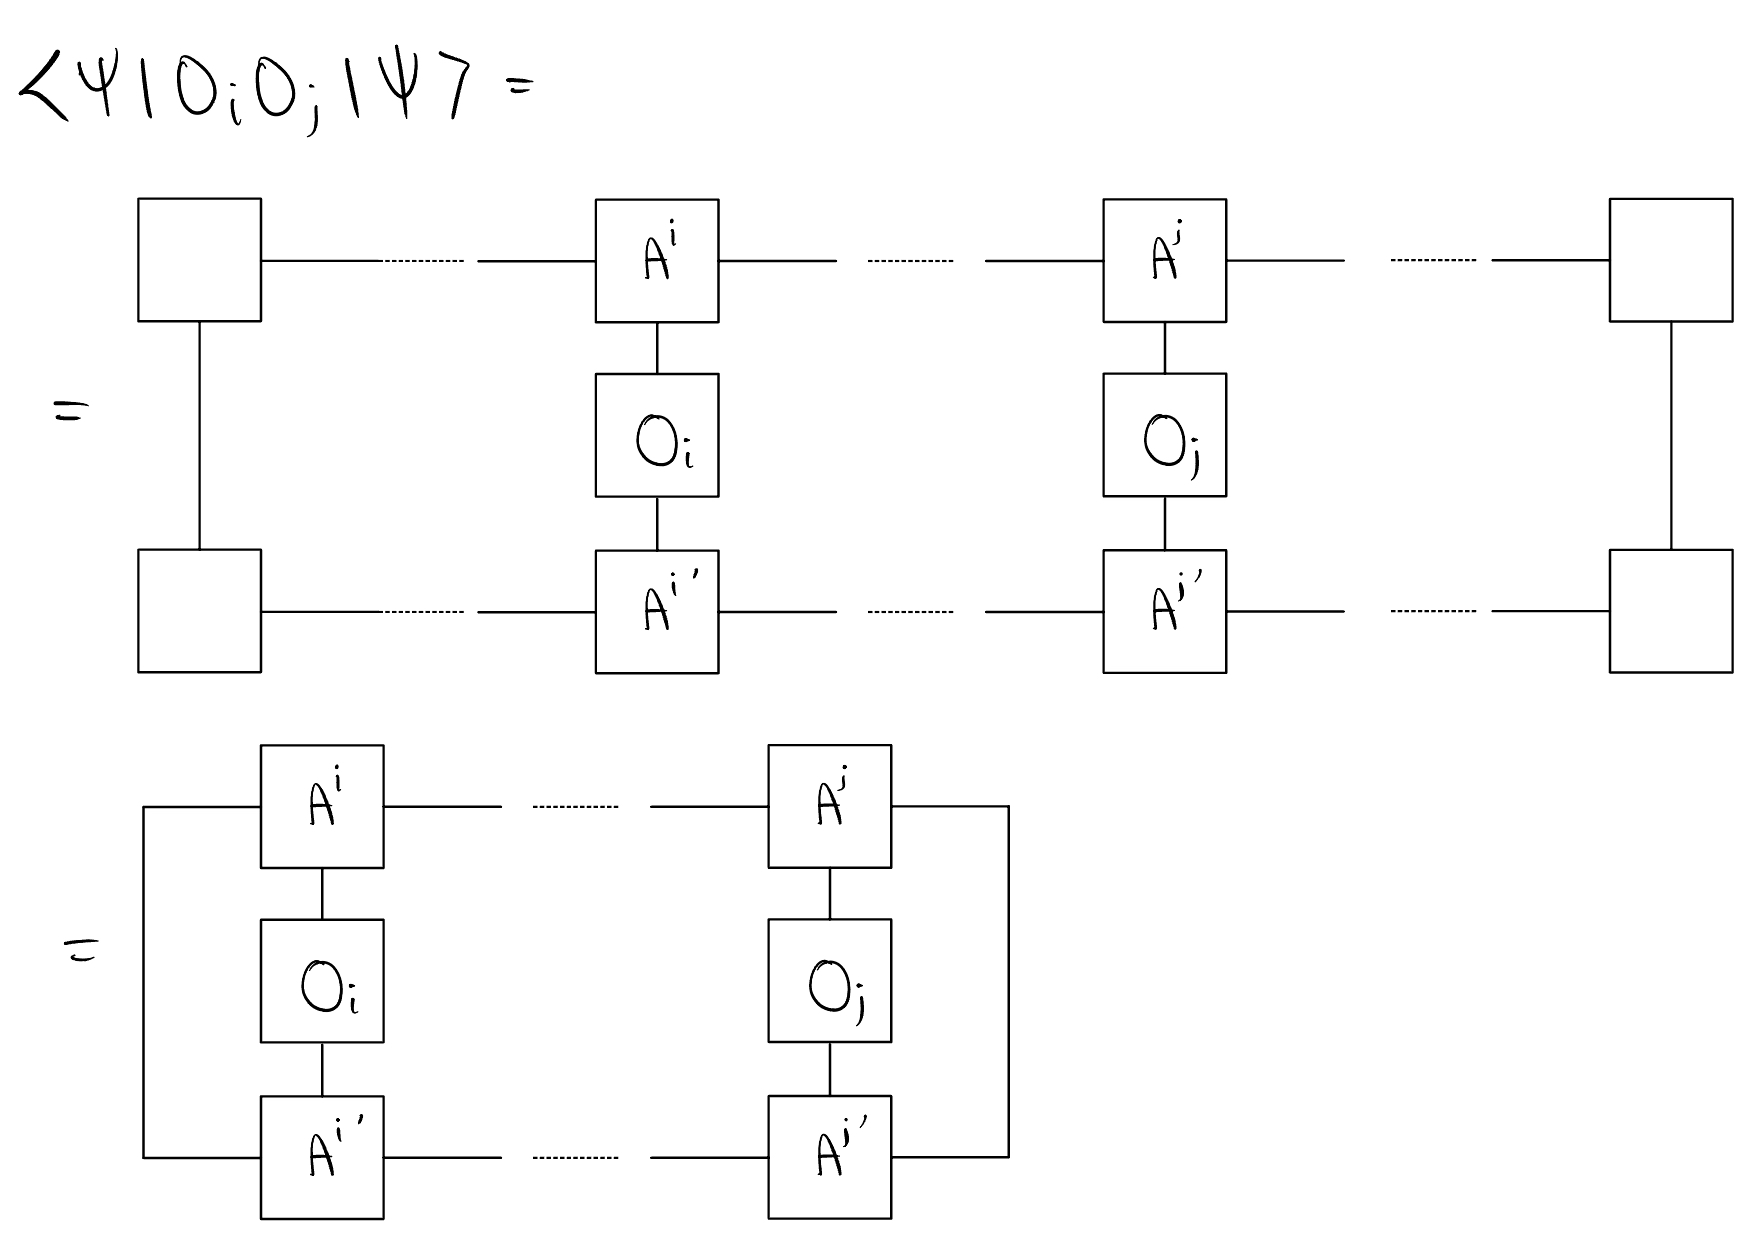

In [117]:
L = 5
psi = NeelMPS(L)
psi_mps = MPSrep(psi)

MPSrep(1, -1, Array{Float64, N} where N[[1.0 0.0], [0.0 1.0], [1.0 0.0], [0.0 1.0], [1.0 0.0]])

In [118]:
i0 = 1
j0 = L

# Move the orthogonality center to site i0
OrthogonalizePsi!(psi_mps, i0)
Ai0 = psi_mps.state[i0]
M0 = size(Ai0)[1]
M1 = size(Ai0)[3]

# Initialize tensors for Ai * Sz
Ai_Sop = zeros(M0, 2, M1)
@tensor Ai_Sop[l0, sp, l1] = Ai0[l0, s, l1] * Sz[s, sp]

# Calculate Ai * Sz * Ai'
AiAip = zeros(M1, M1)
@tensor AiAip[l1, l1p] = Ai_Sop[l0, sp, l1] * Ai0[l0, sp, l1p]

# Iterate from i0+1 to j0-1
for k in i0+1:j0-1
    Ak = psi_mps.state[k]
    M2 = size(Ak)[3]

    # Initialize tensors for AiAip * Ak
    AiAip_Ak = zeros(M1, 2, M2)
    @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Ak[l1, s, l2]

    # Calculate AiAip * Ak * AiAip'
    AiAip = zeros(M2, M2)
    @tensor AiAip[l2, l2p] = AiAip_Ak[l1p, s, l2] * Ak[l1p, s, l2p]

    # Update M1 for the next iteration
    M1 = M2
end

# Calculate AiAip * Ak * AiAip' * Sz
Aj0 = psi_mps.state[j0]
M2 = size(Aj0)[3]
AiAip_Ak = zeros(M1, 2, M2)
@tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Aj0[l1, s, l2]
AiAip_Ak_Sz = zeros(M1, 2, M2)
@tensor AiAip_Ak_Sz[l1p, sp, l2] = AiAip_Ak[l1p, s, l2] * Sz[s, sp]

# Calculate the final expectation value Sz * Sz
@tensor SzSzVal = AiAip_Ak_Sz[l1p, sp, l2] * Aj0[l1p, sp, l2]

1.0

In [119]:
function CorrelationsByLength(psi_mps::MPSrep, Op)
    """
    CorrelationsByLength(psi_mps::MPSrep, Op)

    Calculate correlations by length for an operator (Op) in a Matrix Product State (MPS).

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `Op`: The operator for which to calculate the correlations.

    # Returns
    An array of correlation values for each site.

    """
    i0 = 1
    Corr = []

    # Move the orthogonality center to the first site
    OrthogonalizePsi!(psi_mps, i0)
    Ai0 = psi_mps.state[i0]
    M0 = size(Ai0)[1]
    M1 = size(Ai0)[3]

    # Initialize tensors for Ai * Op
    Ai_Sop = zeros(M0, 2, M1)
    @tensor Ai_Sop[l0, sp, l1] = Ai0[l0, s, l1] * Op[s, sp]

    # Calculate Ai * Op * Ai'
    AiAip = zeros(M1, M1)
    @tensor AiAip[l1, l1p] = Ai_Sop[l0, sp, l1] * Ai0[l0, sp, l1p]

    for j0 in 2:L
        # Iterate from i0+1 to j0-1
        for k in i0+1:j0-1
            Ak = psi_mps.state[k]
            M2 = size(Ak)[3]

            # Initialize tensors for AiAip * Ak
            AiAip_Ak = zeros(M1, 2, M2)
            @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Ak[l1, s, l2]

            # Calculate AiAip * Ak * AiAip'
            AiAip = zeros(M2, M2)
            @tensor AiAip[l2, l2p] = AiAip_Ak[l1p, s, l2] * Ak[l1p, s, l2p]

            # Update M1 for the next iteration
            M1 = M2
        end

        Aj0 = psi_mps.state[j0]
        M2 = size(Aj0)[3]

        # Initialize tensors for AiAip * Ak * Op
        AiAip_Ak = zeros(M1, 2, M2)
        @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Aj0[l1, s, l2]
        AiAip_Ak_Op = zeros(M1, 2, M2)
        @tensor AiAip_Ak_Op[l1p, sp, l2] = AiAip_Ak[l1p, s, l2] * Op[s, sp]

        # Calculate AiAip * Ak * Op * Aj0'
        @tensor Val = AiAip_Ak_Op[l1p, sp, l2] * Aj0[l1p, sp, l2]

        # Store the correlation value
        push!(Corr, Val)
    end

    return Corr
end

CorrelationsByLength (generic function with 1 method)

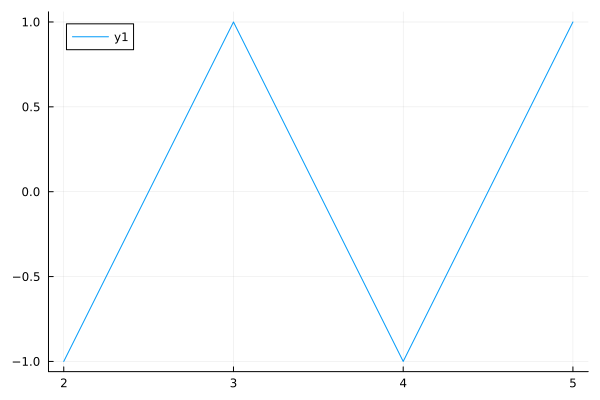

In [120]:
szcorr = CorrelationsByLength(psi_mps, Sz)
plot(2:5, szcorr)

# TEBD

In [122]:
function BondH(h1::Float64, h2::Float64)
    """
    BondH(h1::Float64, h2::Float64)

    Generate the bond Hamiltonian matrix for a two-site bond in the Transverse Field Ising Model (TFIM).

    # Arguments
    - `h1`: Coefficient for the Sx⨂Id term.
    - `h2`: Coefficient for the Id⨂Sx term.

    # Returns
    The Hamiltonian matrix for the two-site bond in the TFIM.

    """
    # Pauli matrices
    Sx = [0.0 1.0; 1.0 0.0]
    Sz = [1.0 0.0; 0.0 -1.0]
    Id = [1.0 0.0; 0.0 1.0]

    # Construct the Hamiltonian matrix for the two-site bond in the TFIM
    Hb = -kron(Sz, Sz) + h1 * kron(Sx, Id) + h2 * kron(Id, Sx)
    
    return Hb
end

BondH (generic function with 1 method)

In [123]:
function GateTensor(dt::Float64, h1::Float64, h2::Float64)
    """
    GateTensor(dt::Float64, h1::Float64, h2::Float64)

    Generate the gate tensor for a time evolution step in the Transverse Field Ising Model (TFIM).

    # Arguments
    - `dt`: Time step for the evolution.
    - `h1`: Coefficient for the Sx⨂Id term.
    - `h2`: Coefficient for the Id⨂Sx term.

    # Returns
    The gate tensor for the time evolution step in the TFIM.

    """
    # Generate the Hamiltonian matrix for the two-site bond in the TFIM
    Hb = BondH(h1, h2)

    # Construct the gate tensor for the time evolution step using the Hamiltonian
    G = exp(-dt/2 * Hb)

    # Reshape the gate tensor to a 4-index tensor
    return reshape(G, (2, 2, 2, 2))
end

GateTensor (generic function with 1 method)

In [124]:
function ApplyGate!(psi::Vector{Array{Float64}}, op::Array{Float64}, b::Int64, ortho_left=true, maxM=-1, renorm=false)
    """
    ApplyGate!(psi::Vector{Array{Float64}}, op::Array{Float64}, b::Int64, ortho_left=true, maxM=-1, renorm=false)

    Apply a gate to a specific bond in the Matrix Product State (MPS) representation.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `op`: Array representing the gate to be applied.
    - `b`: Index of the bond where the gate is applied.
    - `ortho_left`: If true, update the left canonical form after applying the gate. Default is true.
    - `maxM`: Maximum bond dimension. If -1, no truncation is performed. Default is -1.
    - `renorm`: If true, renormalize singular values after applying the gate. Default is false.

    # Returns
    The truncation error if truncation is performed.

    """
    trunc = 0.

    # Calculate the bond tensor for the current bond
    psi_bond = BondTensor(psi, b)

    # Initialize a new bond tensor after applying the gate
    new_psi_bond = zeros(size(psi_bond))
    
    # Contract the gate with the current bond tensor to obtain the new bond tensor
    @tensor new_psi_bond[l0, s1p, s2p, l2] = op[s2p, s1p, s2, s1] * psi_bond[l0, s1, s2, l2]

    # Update the MPS by applying the new bond tensor
    trunc = SvdBondTensor!(psi, b, new_psi_bond, ortho_left, maxM, renorm)

    return trunc
end

ApplyGate! (generic function with 4 methods)

In [125]:
function iTEBD_sweep!(psi::Vector{Array{Float64}}, dt::Float64, h::Float64, maxM::Int64)
    """
    iTEBD_sweep!(psi::Vector{Array{Float64}}, dt::Float64, h::Float64, maxM::Int64)

    Perform a single sweep of the imaginary time evolution using Time-Evolving Block Decimation (iTEBD).

    # Arguments
    - `psi`: Array of matrices representing the Matrix Product State (MPS).
    - `dt`: Time step for the evolution.
    - `h`: Transverse field strength.
    - `maxM`: Maximum bond dimension.

    # Returns
    The maximum truncation error during the sweep.

    """
    L = length(psi)
    
    maxTrunc = 0.

    # Sweep right
    for i in range(1, stop=L-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2
        gateOp = GateTensor(dt, h1, h2)
        
        # Apply the gate, update orthogonality center to the right, and renormalize
        trunc = ApplyGate!(psi, gateOp, i, true, maxM, true)
        
        # Update the maximum truncation error
        if trunc > maxTrunc
            maxTrunc = trunc
        end
    end
    
    # Sweep left
    for i in range(L-1, stop=1, step=-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2
        gateOp = GateTensor(dt, h1, h2)
        
        # Apply the gate, update orthogonality center to the left, and renormalize
        trunc = ApplyGate!(psi, gateOp, i, false, maxM, true)
        
        # Update the maximum truncation error
        if trunc > maxTrunc
            maxTrunc = trunc
        end
    end
    
    return maxTrunc
end

iTEBD_sweep! (generic function with 1 method)

In [126]:
function CalculateEnergy!(psi::Vector{Array{Float64}}, h::Float64)
    """
    CalculateEnergy!(psi::Vector{Array{Float64}}, h::Float64)

    Calculate the energy of the Matrix Product State (MPS) representation.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `h`: Transverse field strength.

    # Returns
    The total energy of the MPS.

    """
    L = length(psi)
    
    Etot = 0.

    for i in range(1, stop=L-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2
        
        # Generate the Hamiltonian matrix for the two-site bond
        Hb = reshape(BondH(h1, h2), (2, 2, 2, 2))
        
        # Calculate the bond tensor for the current bond
        psi_bond = BondTensor(psi, i)
        
        # Initialize a tensor for H * psi
        H_psi = zeros(size(psi_bond))
        
        # Contract H with the current bond tensor to obtain H * psi
        @tensor H_psi[l0, s1p, s2p, l2] = Hb[s2p, s1p, s2, s1] * psi_bond[l0, s1, s2, l2]
        
        # Contract psi^† * H * psi to obtain the energy contribution
        @tensor psi_H_psi = psi_bond[l0, s1p, s2p, l2] * H_psi[l0, s1p, s2p, l2]
        
        # Accumulate the energy contribution
        Etot += psi_H_psi
        
        # Update the MPS by applying the new bond tensor with left canonical form (no truncation or renormalization)
        SvdBondTensor!(psi, i, psi_bond, true)
    end
    
    return Etot
end

CalculateEnergy! (generic function with 1 method)

In [127]:
L = 3
# psi = RandomMPS(L, 10)
# NormalizePsi!(psi)
psi = NeelMPS(L)
psi_mps = MPSrep(psi)
init_psi = deepcopy(psi)
psi_mps = MPSrep(psi)
@show(psi_mps.oc)
@show(psi_mps.maxM)


h=0.001
beta = 20
dt = 0.1
Nt = Int(beta/dt)

maxM = 10

for ti in range(1, length=Nt)
    trunc = iTEBD_sweep!(psi_mps.state, dt, h, maxM)
    if mod(ti, 10) == 0
        Et = CalculateEnergy!(deepcopy(psi_mps.state), h)
        println("Energy after imaginary time step ", ti, " is ", Et)
    end
end

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is 1.999201577488854
Energy after imaginary time step 20 is 0.571157778254769
Energy after imaginary time step 30 is -1.9974885373772537
Energy after imaginary time step 40 is -1.9999986389474183
Energy after imaginary time step 50 is -2.0000012167511887
Energy after imaginary time step 60 is -2.00000124939796
Energy after imaginary time step 70 is -2.0000012499910427
Energy after imaginary time step 80 is -2.000001250001908
Energy after imaginary time step 90 is -2.0000012500021045
Energy after imaginary time step 100 is -2.000001250002109
Energy after imaginary time step 110 is -2.0000012500021107
Energy after imaginary time step 120 is -2.000001250002108
Energy after imaginary time step 130 is -2.00000125000211
Energy after imaginary time step 140 is -2.0000012500021116
Energy after imaginary time step 150 is -2.0000012500021085
Energy after imaginary time step 160 is -2.0000012500021107
Energy after imaginary time

In [128]:
init_psi

3-element Vector{Array{Float64, N} where N}:
 [1.0 0.0]
 [0.0 1.0]
 [1.0 0.0]

In [129]:
psi_mps.state

3-element Vector{Array{Float64, N} where N}:
 [-0.9999993749818357 0.0005000017494210531]

[5.000105467176504e-7 0.0010000169695024723]
 [-0.9999999687488808 0.00025000135200043425; 1.5623095825858034e-6 0.0012508289049383739]

[1.5132729188845398e-9 1.2496020113223054e-6; -0.00024999959339152465 0.9999991864620758]
 [-0.9999998749990159 0.0005000019525506548; 0.0005000019525506548 0.9999998749990159]

In [130]:
function ContractMPS(psi::Vector{Array{Float64}})
    """
    ContractMPS(psi::Vector{Array{Float64}})

    Contract the Matrix Product State (MPS) to obtain the full state vector.

    # Arguments
    - `psi`: Array of matrices representing the MPS.

    # Returns
    The contracted state vector.

    """
    L = length(psi)

    # Initialize the bond tensor for the first two sites
    M = size(psi[2])[3]
    psi_bond = zeros(1, 2, 2, M)
    @tensor psi_bond[l0, s1, s2, l2] = psi[1][l0, s1, l1] * psi[2][l1, s2, l2]
    psi_bond = reshape(psi_bond, (1, 4, M))

    # Contract the bond tensors for the remaining sites
    for b in range(2, stop=L-2)
        M = size(psi[b+1])[3]
        psi_new = zeros(1, 2^b, 2, M)
        @tensor psi_new[l0, s1, s2, l2] = psi_bond[l0, s1, l1] * psi[b+1][l1, s2, l2]
        psi_bond = reshape(psi_new, (1, 2^(b+1), M))
    end

    # Contract the bond tensor for the last two sites
    psi_new = zeros(1, 2^(L-1), 2, 1)
    @tensor psi_new[l0, s1, s2, l2] = psi_bond[l0, s1, l1] * psi[end][l1, s2, l2]
    psi_bond = reshape(psi_new, (1, 2^L, 1))

    return psi_bond
end

ContractMPS (generic function with 1 method)

In [131]:
reshape(ContractMPS(init_psi), (2^L))

8-element Vector{Float64}:
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [132]:
reshape(ContractMPS(psi_mps.state), (2^L))

8-element Vector{Float64}:
 -0.9999992187314342
  0.0004999999839568035
  0.00025000016427007736
 -8.758407292972675e-7
  0.0004999999861409303
 -5.000041098758396e-7
 -8.745917699560971e-7
  0.0010000173436791613